# Figure 17a: colour plot of the probabilities of re-invasion conditioning on the probability distribution of entering the Wolbachia-only state space from each mixed state

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Importing required libraries

In [1]:
import numpy as np
import importlib
import multiprocessing as mp
import pylab as plt
import time
import random
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

Importing the required scripts

In [2]:
import SSA_random_wolbachia_hholds as sim
import Hughes_model
import Prob_absorb_to_each
import Finding_dictionary_keys

F = Hughes_model.F#_hughes
importlib.reload(sim)   
gillespie = sim.gillespie
prob_reach_absorb = Prob_absorb_to_each.prob_reach_absorb_Hughes
find_keys = Finding_dictionary_keys.find_keys

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

Parameter values

In [3]:
K = 30           # reproductive carrying capacity
d1 = 12/100      # wild-type death rate
d2 = 12/100      # Wolbachia death rate
k = 0.3          # mosquito competition parameter
h = 0.19*100**k  # mosquito competition parameter
b1 = round(d1/F(10,K),2)  # wild-type per capita birth rate
phi = 85/100       # Wolbachia fitness
b2 = b1*phi      # Wolbachia per capita birth rate
v = 9/10         # probability of vertical transmission
u = 10/10        # ratio of unviable offspring produced by an infected male and uninfected female
max_pop = K      # max household size

# create a dictionary to store all parameter values
params_dict_old = {'b1': b1,
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': v,
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }

Construct dictionaries for full state space and transient states (mixed)

In [4]:
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}
trans_dict = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(1,max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}
n_transient = len(trans_dict)       # number of mixed states

Find the probability distributions for entering the Wolbachia-only state space for each mixed state

In [5]:
# initialise array for probability distributions of entering the Wolbachia-only state space from each mixed state
wolb_enter_dist = np.zeros((n_transient,max_pop)) 

for l in range(max_pop):   # looping all the Wolbachia-only states
        absorb_state = np.array([0,l+1])    # current Wolbachia-only state
        # calculating the probability of entering the W-only state from each mixed state
        mixed_state_probs = np.transpose(prob_reach_absorb(state_dict,trans_dict,absorb_state,params_dict_old)[0])[0]
        wolb_enter_dist[:,l] = mixed_state_probs   # storing the probability distributions in an array

In [6]:
### S1 corresponds to the wild-type-only states, S2 to the Wolbachia-only and mixed states
rev_probs = np.zeros(n_transient) # initialise array for reversion probabilities
state_dict_S1 = {index: np.array((i, 0)) for index, i in enumerate([i for i in range(1, max_pop + 1)])}
state_dict_S2 = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}
reach_wild_probs = np.zeros(len(state_dict_S2))

for m in range(max_pop):  # looping all the wild-type-only states
    absorb_state = np.array([m+1,0])  # these are the absorbing states
    # finding the probabbilities of reaching the wildtype states from each Wolbachia-only state
    # sum the proobabilities of reaching each wildtype state for each Wolbachia state
    reach_wild_probs += np.transpose(prob_reach_absorb(state_dict,state_dict_S2,absorb_state,params_dict_old)[0])[0]

for l in range(n_transient): # looping over all the mixed states
    # find the reversion probability conditioning on entering the wolbachia-only states from each mixed state in turn
    rev_probs[l] = (wolb_enter_dist[l,:]/np.sum(wolb_enter_dist[l,:])) @ reach_wild_probs[:max_pop]

Putting the results into the correct format for the colour map

In [7]:
revert_color_vec = np.zeros((max_pop,max_pop))  # initialise colour plot array
    
for k in range(n_transient):      # looping over the mixed states
    indx1, indx2 = trans_dict[k]  # extracting the correct indices 
    # recording the re-invasion probability at the correct indices
    revert_color_vec[indx1-1,indx2-1] = rev_probs[k]

In [30]:
np.mean(rev_probs)  # the mean reversion probability over all initial distributions

0.3913047050981278

Plotting the figure

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


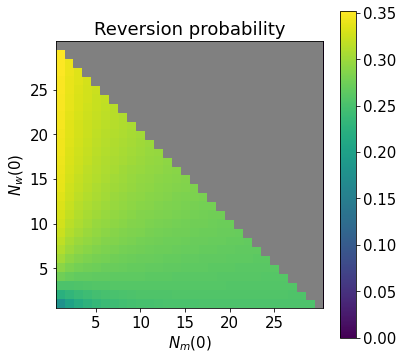

In [8]:
plt.figure(figsize=(6, 6))  # figure size
matplotlib.rcParams.update({'font.size': 15})  # font size

Z = np.transpose(revert_color_vec) # swapping entries to be the correct way round for the colour plot
my_cmap = plt.cm.viridis  # colour scheme
num_levels = 1000000

my_cmap = ListedColormap(my_cmap(np.linspace(0, 1, num_levels))) # choosing how fine the colour grid is
plt.imshow(Z, cmap=my_cmap, interpolation='nearest', origin='lower')  # producing the colour plot

plt.xlabel('$N_m(0)$')   # x labels
plt.ylabel('$N_w(0)$')   # y labels

plt.yticks([4,9,14,19,24],['5','10','15','20','25'])    # y ticks
plt.xticks([4,9,14,19,24],['5','10','15','20','25'])    # x ticks

# colouring in the squares outside of the household size bounds grey 
for i in range(max_pop):    # looping over the y axis
    highlight_row, highlight_col = max_pop-i-1,i
    rect = Rectangle((highlight_col - 0.5, highlight_row - 0.5), max_pop, 1, edgecolor='gray', facecolor='gray')
    current_axes = plt.gca()    # keeping track of axes
    current_axes.add_patch(rect)  # adds grey 

plt.colorbar()   # adds colour bar
plt.title('Reversion probability')   # title

plt.savefig('prob_reversion_initial_dists_qu.pdf', bbox_inches='tight')   # saves figure